In [2]:
import os
import cv2
import torch
import torch.nn as nn
from torchvision import transforms
import numpy as np
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision
import argparse
from iresnet_modified import *
#from vgg_face import *
from basic_config import *
#from utils import transforms_compose
from preprocess_datasets import *
import matplotlib.pyplot as plt
from matplotlib.backends.backend_agg import FigureCanvasAgg

%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

parser = argparse.ArgumentParser(description='DEMO')
parser.add_argument('--mpath', '-p', default='selected_models/DISFAwithPlus_trained/checkpoint_epoch7.pth', type=str,
                    help='the path of model')
#parser.add_argument('--scale', '-s', default=80, type=int,
#                    help='determine the face crop size')
# parser.add_argument('--record', '-r', default='off', choices=['on', 'off'], type=str,
#                     help='determine if recording is on or off')
# parser.add_argument('--record_dir', '-d', default='record', type=str,
#                     help='define the directory name for video save')
# parser.add_argument('--sampling_rate', default=1, choices=[1, 2, 3, 4, 5], type=int,
#                     help='determine the speed of samples fed into network. larger the value, lower the speed. if using a low-end device, use large value')
# parser.add_argument('--camera', '-c', default=0, type=int,
#                     help='the index for the used camera')
# args = parser.parse_args()

#action_units = {p[0]: p[1].replace(' ', '\n') for p in action_units.items()}

2023-11-07 01:17:57.289654: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


_StoreAction(option_strings=['--mpath', '-p'], dest='mpath', nargs=None, const=None, default='selected_models/DISFAwithPlus_trained/checkpoint_epoch7.pth', type=<class 'str'>, choices=None, help='the path of model', metavar=None)

In [3]:
def test_model(model, crop_frame, transform, device):
    model.eval()
    with torch.no_grad():
        #crop_frame = cv2.cvtColor(crop_frame, cv2.COLOR_BGR2RGB)
        crop_frame = transform(crop_frame)
        #crop_frame = np.expand_dims(crop_frame, axis=0)
        crop_frame = crop_frame.unsqueeze(0) # add batch dimension
        crop_frame = torch.tensor(crop_frame, dtype=torch.float).to(device)
        output = model(crop_frame).to(device)
    return output

def plot_bar(au_scores, title, sel_AUs):
    labels = [f"AU{AU}:\n{action_units[AU]}" for AU in sel_AUs]
    colors = plot_colors[:len(sel_AUs)]
    fig, ax = plt.subplots(figsize=(10, 10.8))
    ax.barh(labels, au_scores, color=colors)
    ax.tick_params(axis='both', labelsize=15)
    for label in ax.get_xticklabels() + ax.get_yticklabels():
        label.set_fontname('Times New Roman')
        label.set_fontweight(100)
    #ax.set_title(title + ' PSPI {:.2f}/16'.format(au_scores[0]), fontsize=20)
    ax.set_title(title, fontsize=20)
    ax.set_xlim([0, 5])
    ax.set_ylim(ax.get_ylim()[::-1])
    ax.set_position([0.2, 0.1, 0.7, 0.8])
    canvas = FigureCanvasAgg(fig)
    canvas.draw()
    plot = np.array(canvas.renderer.buffer_rgba())
    return plot

def adaptive_canvas(image_left, image_right):
    h_l, w_l, _ = image_left.shape
    h_r, w_r, _ = image_right.shape
    canvas_h = max(h_l, h_r)
    canvas_w = w_l+w_r
    canvas = np.zeros((canvas_h, canvas_w, 3), dtype=np.uint8)
    canvas[:h_l, :w_l, :] = image_left[:,:,:3]
    canvas[:h_r, w_l:, :] = image_right[:,:,:3]
    return canvas


def transforms_compose(steps, include_random=True):  #, BGR2RGB=True, include_normalize=True):
    if steps[0][0] == 'BGR2RGB':
        BGR2RGB = True
        steps = steps[1:]
    else:
        BGR2RGB = False
    if steps[-1][0] == 'Normalization':
        include_normalize = True
        steps = steps[:-1]
    else:
        include_normalize = False

    transform_list = []
    if BGR2RGB == True:
        transform_list.append(transforms.Lambda(lambda img: img[:, :, ::-1]))
    transform_list.append(transforms.ToPILImage())
    for transform, inp in steps:
        if transform.startswith('Random') and include_random == False:
            continue
        if transform == 'RandomHorizontalFlip':
            transform_list.append(transforms.RandomHorizontalFlip())
        elif transform == 'RandomResizedCrop':
            transform_list.append(
                transforms.RandomResizedCrop(size=inp['size'], scale=inp['scale'], ratio=inp['ratio']))
        elif transform == 'Resize':
            transform_list.append(transforms.Resize(inp))
        else:
            raise ValueError('Unrecognized transformation.')
    transform_list.append(transforms.ToTensor())
    if include_normalize == True:
        transform_list.append(
            transforms.Normalize([0.53720075, 0.42637664, 0.3873985], [0.19015081, 0.19909547, 0.2046528]))
    return transforms.Compose(transform_list)

In [4]:
model_path = "selected_models/DISFAwithPlus_trained/checkpoint_epoch7.pth"
setup_path = os.path.join(os.path.dirname(model_path), 'training_setup.pkl')
with open(setup_path, 'rb') as f:
    setup = pkl.load(f)
preprocess_steps = setup['preprocess']
transform_steps = setup['transform']
sel_AUs = np.array(setup['AUs'])

device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')
model = iresnet_basic(n_layers=50, n_features = n_all_AUs * (max_intensity + 1)).to(device)
for param in model.parameters():
    param.requires_grad = False
model.load_state_dict(torch.load(model_path, map_location=device))

transform = transforms_compose(transform_steps, include_random=False)



In [5]:
def main():
    # add face detection model, choose between:
    # haarcascade_frontalface_default.xml
    # haarcascade_frontalface_alt_tree.xml is preferred
    #face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_alt_tree.xml')
    #     base_options = python.BaseOptions(model_asset_path='mediapipe_models/blaze_face_short_range.tflite')
    #     options = vision.FaceDetectorOptions(base_options=base_options)#, running_mode=vision.RunningMode.VIDEO)
    #     detector = vision.FaceDetector.create_from_options(options)

    # set up a camera window
    cv2.namedWindow('face_cap', cv2.WINDOW_NORMAL)
    cv2.resizeWindow('face_cap', 1500, 600)

    cap = cv2.VideoCapture(0) # changed to support mac
    cap.set(cv2.CAP_PROP_FOURCC, cv2.VideoWriter_fourcc(*"MJPG"))
    cap_w = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    cap_h = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    cap_info = '({}*{}, fps {})'.format(cap_w, cap_h, fps)

    # # create directory for
    # if args.record == 'on':
    #     save_path = './{}/'.format(args.record_dir)
    #     if not os.path.exists(save_path):
    #         os.makedirs(save_path)

    save_count = 0
    while True:
        ret, frame = cap.read()

        # mirror the video
        frame_flip = cv2.flip(frame,1)

        face_detected, crop_frame = preprocess_image(frame_flip, preprocess_steps, device)

        # feed the frame into the model

        try:
            output_text = ''
            output_plot = canvas = np.ones((1080, 1000, 3), dtype=np.uint8)*255 # miguel added
            if face_detected and save_count % 1 == 0:
                output = test_model(model, crop_frame, transform, device)
                output = output.flatten()
                output = torch.Tensor.cpu(output).numpy()
                output_sel_AUs = output[sel_AUs-1]
                output_plot = plot_bar(output_sel_AUs, cap_info, sel_AUs)
                #output_text = '|PSPI {:.2f} |au4 {:.2f} |au6 {:.2f} |au7 {:.2f} |au10 {:.2f} |au12 {:.2f} |au20 {:.2f} |au25 {:.2f} |au26 {:.2f} |au43 {:.2f}|'.format(output[0].item(), output[1].item(), output[2].item(), output[3].item(), output[4].item(), output[5].item(), output[6].item(), output[7].item(), output[8].item(), output[9].item())

            # save video option
            # if args.record == 'on':
            #     filename = save_path + str(save_count) + '.png'
            #     cv2.imwrite(filename, crop_frame)
            #     save_count += 1

        except Exception as error:
            output_plot = canvas = np.ones((1080, 1000, 3), dtype=np.uint8)*255
            output_text = str(error)

        # print AU info at the bottom of each frame
        font = cv2.FONT_HERSHEY_SIMPLEX
        font_scale = 0.5
        #thickness = 2
        text_size, _ = cv2.getTextSize(output_text, font, font_scale, 2)
        text_x = int((cap_w - text_size[0]) / 2)
        text_y = cap_h - text_size[1] - 10
        cv2.putText(frame_flip, output_text, (text_x, text_y), font, font_scale, (255, 255, 255), 2)

        # dispay canvas
        canvas = adaptive_canvas(frame_flip, output_plot)
        cv2.imshow('face_cap', canvas)

        # Press 'Q' to quit camera
        if cv2.waitKey(1) == ord('q'):
            break

    # After the loop release the cap object
    cap.release()
    # Destroy all the windows
    cv2.destroyAllWindows()

In [6]:
def run_image_through_cell(image_path):
    # Read the image using OpenCV
    frame = cv2.imread(image_path)

    # The existing preprocessing and model steps
    face_detected, crop_frame = preprocess_image(frame, preprocess_steps, device)
    output_text = ''
    output_plot = np.ones((1080, 1000, 3), dtype=np.uint8) * 255  # Initialize the plot

    if face_detected:
        output = test_model(model, crop_frame, transform, device)
        output = output.flatten()
        output = torch.Tensor.cpu(output).numpy()
        output_sel_AUs = output[sel_AUs-1]
      #  output_plot = plot_bar(output_sel_AUs, 'Image Analysis', sel_AUs)



    # Create an adaptive canvas
    canvas = adaptive_canvas(frame, output_plot)

    # Display the final canvas using Matplotlib (since we are in a notebook)
   # plt.imshow(cv2.cvtColor(canvas, cv2.COLOR_BGR2RGB))
   # plt.show()
    return output_sel_AUs

In [7]:
run_image_through_cell("/Users/miguelmonares/FAU2/images/European_Man/em10/4em10_4.10.png")

array([-0.00488559,  0.03617974,  2.1242285 ,  0.83716017,  0.08285362,
        0.07709565, -0.04959476,  0.03416335,  0.02191721, -0.03772489,
       -0.0302091 ,  0.14053091], dtype=float32)

In [8]:
run_image_through_cell("/Users/miguelmonares/FAU2/images/European_Man/em1/4em1_4.10.png")

array([ 0.00726176,  0.00246021,  1.974854  ,  0.08775591,  0.0632055 ,
        0.0195689 , -0.05246769,  0.04416776, -0.02021753, -0.00553998,
       -0.02538016,  0.13397469], dtype=float32)

In [9]:
from scipy.stats import ttest_ind
import matplotlib.pyplot as plt
import numpy as np
import cv2

def plot_bar1(au_scores, title, sel_AUs, ax):
    labels = [f"AU{AU}" for AU in sel_AUs]  # You can adjust the labels as per your need
    colors = plot_colors[:len(sel_AUs)]
    ax.barh(labels, au_scores, color=colors)
    ax.tick_params(axis='both', labelsize=15)
    ax.set_title(title, fontsize=20)
    ax.set_xlim([0, 5])
    ax.set_ylim(ax.get_ylim()[::-1])

def compare_two_images(image_path1, image_path2):
    fig, axs = plt.subplots(1, 2, figsize=(15, 7))

    for idx, image_path in enumerate([image_path1, image_path2]):
        frame = cv2.imread(image_path)
        face_detected, crop_frame = preprocess_image(frame, preprocess_steps, device)

        if face_detected:
            output = test_model(model, crop_frame, transform, device)
            output = output.flatten()
            output = torch.Tensor.cpu(output).numpy()
            output_sel_AUs = output[sel_AUs-1]

            if idx == 0:
                au_scores1 = output_sel_AUs
            else:
                au_scores2 = output_sel_AUs

            plot_bar1(output_sel_AUs, f"Analysis of {image_path.split('/')[-1]}", sel_AUs, axs[idx])

    plt.tight_layout()
    plt.show()

    # Run statistical tests only if both images were processed successfully
    if 'au_scores1' in locals() and 'au_scores2' in locals():
        t_stat, p_val = ttest_ind(au_scores1, au_scores2)
        print(f"t-statistic: {t_stat}, p-value: {p_val}")

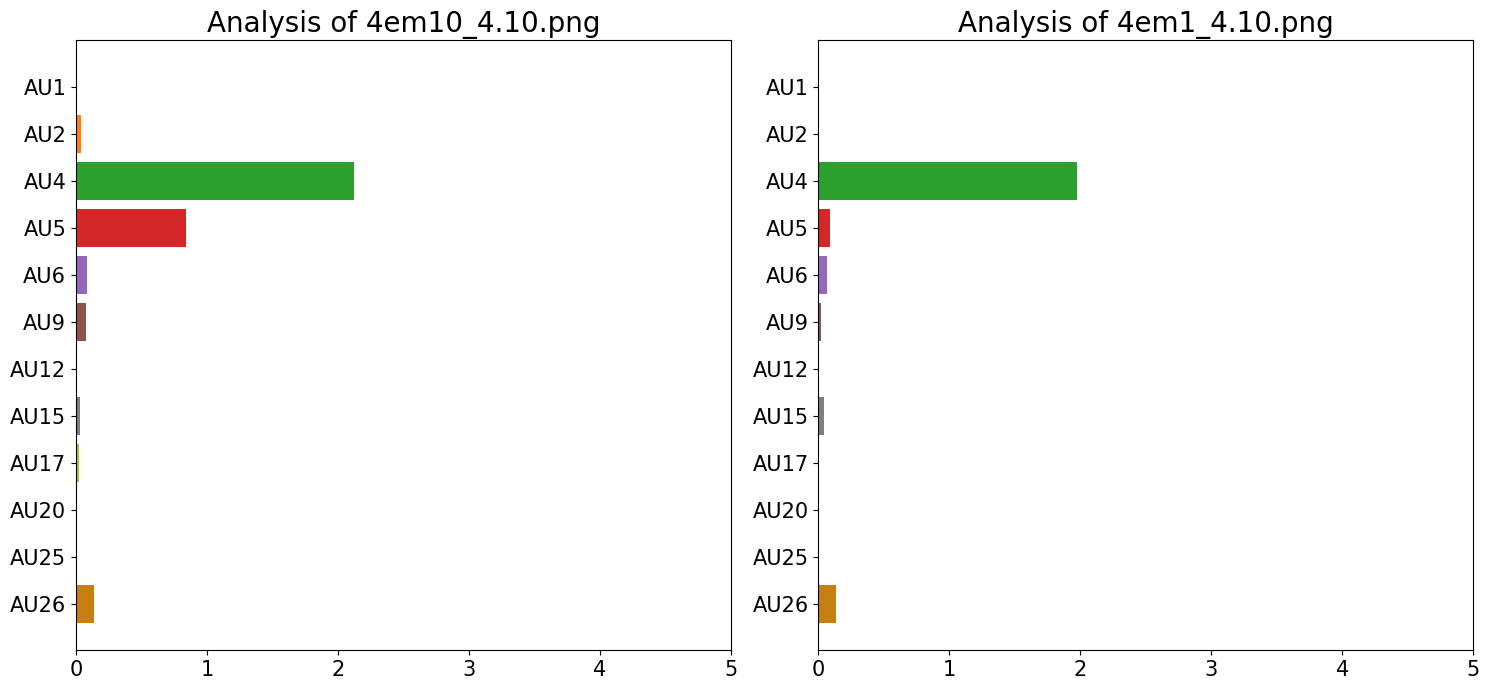

t-statistic: 0.3412383245351992, p-value: 0.736161795265847


In [10]:
compare_two_images("/Users/miguelmonares/FAU2/images/European_Man/em10/4em10_4.10.png",
                   "/Users/miguelmonares/FAU2/images/European_Man/em1/4em1_4.10.png")

In [11]:
import os
import cv2
import pandas as pd

def process_images(folder_path):
    # List all files in the folder
    files = os.listdir(folder_path)

    # Filter files starting with '4' and exclude those starting with '43'
    image_files = [file for file in files if file.startswith('12') and not file.startswith('43')]

    # Initialize an empty list to hold the data
    data = []
    image_files = sorted(image_files)
    image_files.append(image_files.pop(0))
    for image_file in image_files:
        # Read the image
        image_path = os.path.join(folder_path, image_file)
        image = cv2.imread(image_path)

        # Process the image using the model
        output = run_image_through_cell(image_path)

        # Create a dictionary with the image name and output values
        row = {
            'Image': image_file,
            'AU1': output[0].item(),
            'AU2': output[1].item(),
            'AU4': output[2].item(),
            'AU5': output[3].item(),
            'AU6': output[4].item(),
            'AU9': output[5].item(),
            'AU12': output[6].item(),
            'AU15': output[7].item(),
            'AU17': output[8].item(),
            'AU20': output[9].item(),
            'AU25': output[10].item(),
            'AU26': output[11].item()
        }

        # Append the row to the data list
        data.append(row)

    # Create a DataFrame from the data list
    df = pd.DataFrame(data)

    # Print the DataFrame
    #print(df)

    # Return the DataFrame
    return df

In [12]:
test4_10 = process_images('/Users/miguelmonares/FAU2/images/European_Man/em10')

In [13]:
test4_10

,Image,AU1,AU2,AU4,AU5,AU6,AU9,AU12,AU15,AU17,AU20,AU25,AU26
0,12em10_12.2.png,0.025869,-0.034503,-0.006237,0.262352,0.061384,0.005499,0.257312,0.018527,0.018377,-0.042035,0.089187,0.056772
1,12em10_12.4.png,0.007694,-0.051315,-0.006920,0.143182,0.110950,0.010806,1.219759,0.025051,-0.007858,-0.002664,0.091845,0.039104
2,12em10_12.6.png,0.012858,0.008524,-0.016251,0.102699,0.752343,0.016066,2.120927,0.036994,-0.012398,0.068469,0.053019,0.061700
3,12em10_12.8.png,0.050841,0.040810,-0.079831,0.166997,1.290242,-0.047486,2.563555,0.018419,-0.009842,0.116240,0.051165,0.151119
4,12em10_12.10.png,0.033101,0.053488,-0.072964,0.188447,1.448403,-0.046268,2.666520,0.005580,0.093122,0.242971,0.085439,0.215553


In [14]:
from sklearn.metrics.pairwise import cosine_similarity


In [15]:
def plot_columns_together2(folder_path, column_name, save_path=None):
    color_scale = ['#f6ede4', '#f3e7db', '#f7ead0', '#eadaba', '#d7bd96', '#a07e56', '#825c43', '#604134', '#3a312a', '#292420']

    plt.figure(figsize=(8, 6))
    df_results = pd.DataFrame(columns=['Skin Tone', 'Slope', 'Mean Absolute Difference from True AU Activation'])

    folder_list = sorted([folder_name for folder_name in os.listdir(folder_path) if not folder_name.startswith('.')])
    folder_list.append(folder_list.pop(1))
    print(folder_list)

    first_folder = os.path.join(folder_path, folder_list[0])
    last_folder = os.path.join(folder_path, folder_list[-1])
    df_first = process_images(first_folder)  # Obtain the dataframe for the first folder
    df_last = process_images(last_folder)  # Obtain the dataframe for the last folder

    for i, folder_name in enumerate(folder_list):
        current_folder = os.path.join(folder_path, folder_name)

        df = process_images(current_folder)  # Obtain the dataframe for the current folder

        values = df[column_name]

        # Calculate the mean absolute difference from the first folder
        mean_abs_diff = np.mean(np.abs(values - df_first[column_name]))

        # Calculate the mean absolute difference from the ground truth (True AU Activation)
        mean_abs_diff_from_true = np.mean(np.abs(values - range(0, len(values))))

        # Calculate the cosine similarity
        cosine_sim = cosine_similarity(values.values.reshape(1, -1),
                                       df_first[column_name].values.reshape(1, -1))[0, 0]

        # Perform linear regression on each dataset
        slope, _ = np.polyfit(range(len(values)), values, 1)
        print(f"Slope of Skin Tone {i+1}: {slope:.4f}")
        print(f"Mean Absolute Difference from True AU Activation: {mean_abs_diff_from_true:.4f}")
        print()

        # Store the results in the DataFrame
        df_results = pd.concat([df_results, pd.DataFrame({'Skin Tone': [str(i+1)],
                                                          'Slope': [slope],
                                                          'Mean Absolute Difference from True AU Activation': [mean_abs_diff_from_true]})],
                               ignore_index=True)

        # Plot the values from the current DataFrame with the specified color
        plt.plot(range(0, len(values)), values, label=f'Skin Tone {i+1}', marker='o', color=color_scale[i])

    plt.xlabel('True AU Activation')
    plt.ylabel('Pred AU Activation')
    plt.title(f"{column_name} Activation Comparison")
    plt.legend()
    plt.ylim(0, 5)
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300)  # Save the plot to a PNG file

    plt.show()

    print("Results:")
    print(df_results[['Skin Tone', 'Slope', 'Mean Absolute Difference from True AU Activation']])

In [35]:
# plot_columns_together2('/Users/miguelmonares/FAU2/images/European_Woman', 'AU4')

In [34]:
# plot_columns_together2('/Users/miguelmonares/FAU2/images/European_Woman', 'AU9')

In [36]:
# plot_columns_together2('/Users/miguelmonares/FAU2/images/European_Woman', 'AU25')


In [37]:
# plot_columns_together2('/Users/miguelmonares/FAU2/images/European_Woman', 'AU6')


In [38]:
# plot_columns_together2('/Users/miguelmonares/FAU2/images/European_Woman', 'AU12')

In [24]:
import os
import cv2
import pandas as pd

def process_images_new(folder_path, AU):
    # List all files in the folder
    files = os.listdir(folder_path)

    # Filter files starting with '4' and exclude those starting with '43'
    image_files = [file for file in files if file.startswith(AU) and not file.startswith('43')]

    # Initialize an empty list to hold the data
    data = []
    image_files = sorted(image_files)
    image_files.append(image_files.pop(0))
    for image_file in image_files:
        # Read the image
        image_path = os.path.join(folder_path, image_file)
        image = cv2.imread(image_path)

        # Process the image using the model
        output = run_image_through_cell(image_path)

        # Create a dictionary with the image name and output values
        row = {
            'Image': image_file,
            'AU1': output[0].item(),
            'AU2': output[1].item(),
            'AU4': output[2].item(),
            'AU5': output[3].item(),
            'AU6': output[4].item(),
            'AU9': output[5].item(),
            'AU12': output[6].item(),
            'AU15': output[7].item(),
            'AU17': output[8].item(),
            'AU20': output[9].item(),
            'AU25': output[10].item(),
            'AU26': output[11].item()
        }

        # Append the row to the data list
        data.append(row)

    # Create a DataFrame from the data list
    df = pd.DataFrame(data)

    # Print the DataFrame
    #print(df)

    # Return the DataFrame
    return df

In [25]:
def plot_columns_together_new(folder_path, column_name, AU, save_path=None):
    color_scale = ['#f6ede4', '#f3e7db', '#f7ead0', '#eadaba', '#d7bd96', '#a07e56', '#825c43', '#604134', '#3a312a',
                   '#292420']

    plt.figure(figsize=(8, 6))
    df_results = pd.DataFrame(columns=['Skin Tone', 'Slope', 'Mean Absolute Difference from True AU Activation'])

    folder_list = sorted([folder_name for folder_name in os.listdir(folder_path) if not folder_name.startswith('.')])
    folder_list.append(folder_list.pop(1))
    print(folder_list)

    first_folder = os.path.join(folder_path, folder_list[0])
    last_folder = os.path.join(folder_path, folder_list[-1])
    df_first = process_images(first_folder)  # Obtain the dataframe for the first folder
    df_last = process_images(last_folder)  # Obtain the dataframe for the last folder

    for i, folder_name in enumerate(folder_list):
        current_folder = os.path.join(folder_path, folder_name)

        df = process_images_new(current_folder, AU)  # Obtain the dataframe for the current folder

        values = df[column_name]

        # Calculate the mean absolute difference from the first folder
        mean_abs_diff = np.mean(np.abs(values - df_first[column_name]))

        # Calculate the mean absolute difference from the ground truth (True AU Activation)
        mean_abs_diff_from_true = np.mean(np.abs(values - range(0, len(values))))

        # Calculate the cosine similarity
        cosine_sim = cosine_similarity(values.values.reshape(1, -1),
                                       df_first[column_name].values.reshape(1, -1))[0, 0]

        # Perform linear regression on each dataset
        slope, _ = np.polyfit(range(len(values)), values, 1)
        print(f"Slope of Skin Tone {i + 1}: {slope:.4f}")
        print(f"Mean Absolute Difference from True AU Activation: {mean_abs_diff_from_true:.4f}")
        print()

        # Store the results in the DataFrame
        df_results = pd.concat([df_results, pd.DataFrame({'Skin Tone': [str(i + 1)],
                                                          'Slope': [slope],
                                                          'Mean Absolute Difference from True AU Activation': [
                                                              mean_abs_diff_from_true]})],
                               ignore_index=True)

        # Plot the values from the current DataFrame with the specified color
        plt.plot(range(0, len(values)), values, label=f'Skin Tone {i + 1}', marker='o', color=color_scale[i])

    plt.xlabel('True AU Activation')
    plt.ylabel('Pred AU Activation')
    plt.title(f"{column_name} Activation Comparison")
    plt.legend()
    plt.ylim(0, 5)
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300)  # Save the plot to a PNG file

    plt.show()

    print("Results:")
    print(df_results[['Skin Tone', 'Slope', 'Mean Absolute Difference from True AU Activation']])

['ew1', 'ew2', 'ew3', 'ew4', 'ew5', 'ew6', 'ew7', 'ew8', 'ew9', 'ew10']
Slope of Skin Tone 1: 0.6800
Mean Absolute Difference from True AU Activation: 0.7946

Slope of Skin Tone 2: 0.6871
Mean Absolute Difference from True AU Activation: 0.7799

Slope of Skin Tone 3: 0.6843
Mean Absolute Difference from True AU Activation: 0.7883

Slope of Skin Tone 4: 0.6860
Mean Absolute Difference from True AU Activation: 0.7609

Slope of Skin Tone 5: 0.6901
Mean Absolute Difference from True AU Activation: 0.7613

Slope of Skin Tone 6: 0.7020
Mean Absolute Difference from True AU Activation: 0.7400

Slope of Skin Tone 7: 0.6964
Mean Absolute Difference from True AU Activation: 0.6873

Slope of Skin Tone 8: 0.7191
Mean Absolute Difference from True AU Activation: 0.6050

Slope of Skin Tone 9: 0.7629
Mean Absolute Difference from True AU Activation: 0.5841

Slope of Skin Tone 10: 0.7630
Mean Absolute Difference from True AU Activation: 0.3975



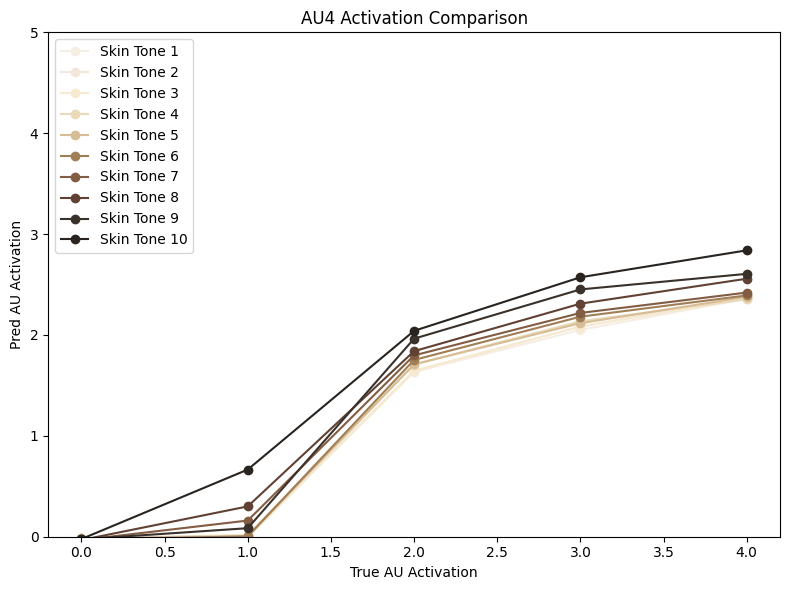

Results:
  Skin Tone     Slope  Mean Absolute Difference from True AU Activation
0         1  0.680022                                          0.794582
1         2  0.687122                                          0.779931
2         3  0.684308                                          0.788280
3         4  0.686015                                          0.760915
4         5  0.690143                                          0.761298
5         6  0.702020                                          0.740011
6         7  0.696398                                          0.687273
7         8  0.719084                                          0.605000
8         9  0.762945                                          0.584086
9        10  0.762951                                          0.397478


In [26]:
plot_columns_together_new('/Users/miguelmonares/FAU2/images/European_Woman', 'AU4', '4')

['ew1', 'ew2', 'ew3', 'ew4', 'ew5', 'ew6', 'ew7', 'ew8', 'ew9', 'ew10']
Slope of Skin Tone 1: 0.0056
Mean Absolute Difference from True AU Activation: 1.9536

Slope of Skin Tone 2: 0.0035
Mean Absolute Difference from True AU Activation: 1.9557

Slope of Skin Tone 3: 0.0046
Mean Absolute Difference from True AU Activation: 1.9572

Slope of Skin Tone 4: 0.0037
Mean Absolute Difference from True AU Activation: 1.9580

Slope of Skin Tone 5: 0.0047
Mean Absolute Difference from True AU Activation: 1.9600

Slope of Skin Tone 6: 0.0020
Mean Absolute Difference from True AU Activation: 1.9709

Slope of Skin Tone 7: 0.0018
Mean Absolute Difference from True AU Activation: 1.9732

Slope of Skin Tone 8: -0.0003
Mean Absolute Difference from True AU Activation: 1.9768

Slope of Skin Tone 9: 0.0031
Mean Absolute Difference from True AU Activation: 1.9706

Slope of Skin Tone 10: 0.0033
Mean Absolute Difference from True AU Activation: 1.9736



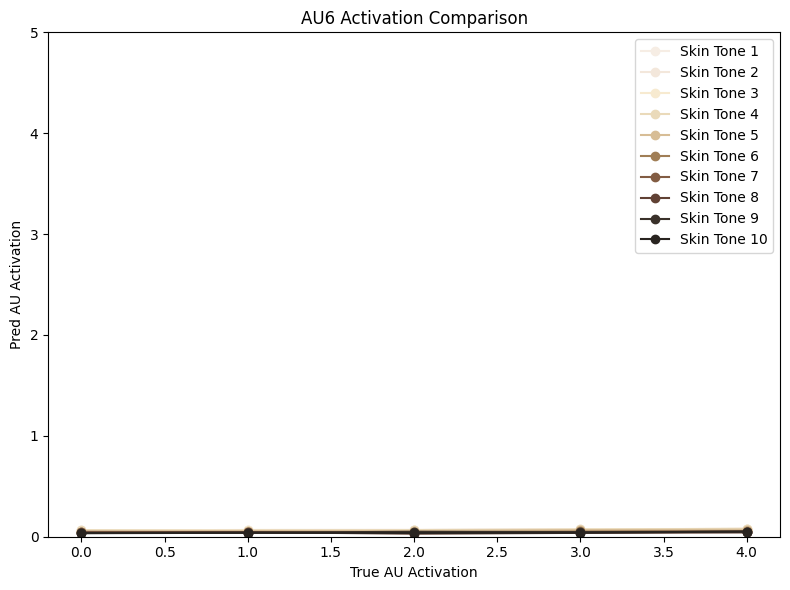

Results:
  Skin Tone     Slope  Mean Absolute Difference from True AU Activation
0         1  0.005638                                          1.953568
1         2  0.003481                                          1.955745
2         3  0.004574                                          1.957209
3         4  0.003665                                          1.957977
4         5  0.004716                                          1.959958
5         6  0.002012                                          1.970946
6         7  0.001780                                          1.973245
7         8 -0.000258                                          1.976778
8         9  0.003102                                          1.970586
9        10  0.003350                                          1.973609


In [27]:
plot_columns_together_new('/Users/miguelmonares/FAU2/images/European_Woman', 'AU6', '6')

['ew1', 'ew2', 'ew3', 'ew4', 'ew5', 'ew6', 'ew7', 'ew8', 'ew9', 'ew10']
Slope of Skin Tone 1: 0.0871
Mean Absolute Difference from True AU Activation: 1.9029

Slope of Skin Tone 2: 0.0985
Mean Absolute Difference from True AU Activation: 1.8906

Slope of Skin Tone 3: 0.1024
Mean Absolute Difference from True AU Activation: 1.8863

Slope of Skin Tone 4: 0.1181
Mean Absolute Difference from True AU Activation: 1.8714

Slope of Skin Tone 5: 0.1333
Mean Absolute Difference from True AU Activation: 1.8572

Slope of Skin Tone 6: 0.1551
Mean Absolute Difference from True AU Activation: 1.8359

Slope of Skin Tone 7: 0.1548
Mean Absolute Difference from True AU Activation: 1.8410

Slope of Skin Tone 8: 0.1707
Mean Absolute Difference from True AU Activation: 1.8263

Slope of Skin Tone 9: 0.2674
Mean Absolute Difference from True AU Activation: 1.6986

Slope of Skin Tone 10: 0.2691
Mean Absolute Difference from True AU Activation: 1.6881



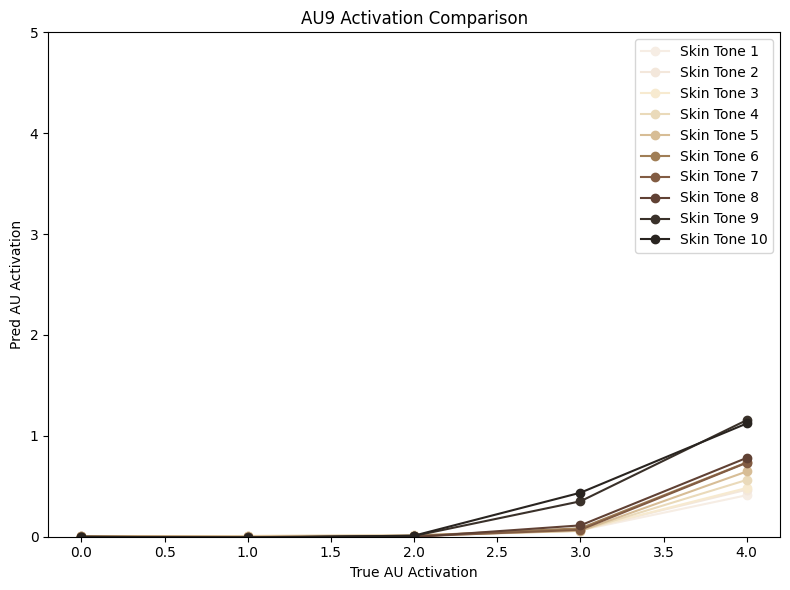

Results:
  Skin Tone     Slope  Mean Absolute Difference from True AU Activation
0         1  0.087140                                          1.902943
1         2  0.098474                                          1.890597
2         3  0.102400                                          1.886338
3         4  0.118102                                          1.871438
4         5  0.133284                                          1.857224
5         6  0.155078                                          1.835911
6         7  0.154778                                          1.841030
7         8  0.170716                                          1.826284
8         9  0.267401                                          1.698616
9        10  0.269100                                          1.688089


In [28]:
plot_columns_together_new('/Users/miguelmonares/FAU2/images/European_Woman', 'AU9', '9')

['ew1', 'ew2', 'ew3', 'ew4', 'ew5', 'ew6', 'ew7', 'ew8', 'ew9', 'ew10']
Slope of Skin Tone 1: 0.5865
Mean Absolute Difference from True AU Activation: 0.5031

Slope of Skin Tone 2: 0.5936
Mean Absolute Difference from True AU Activation: 0.4955

Slope of Skin Tone 3: 0.5812
Mean Absolute Difference from True AU Activation: 0.5240

Slope of Skin Tone 4: 0.5875
Mean Absolute Difference from True AU Activation: 0.5114

Slope of Skin Tone 5: 0.5741
Mean Absolute Difference from True AU Activation: 0.5191

Slope of Skin Tone 6: 0.5673
Mean Absolute Difference from True AU Activation: 0.5240

Slope of Skin Tone 7: 0.5546
Mean Absolute Difference from True AU Activation: 0.5343

Slope of Skin Tone 8: 0.5528
Mean Absolute Difference from True AU Activation: 0.5335

Slope of Skin Tone 9: 0.5294
Mean Absolute Difference from True AU Activation: 0.5665

Slope of Skin Tone 10: 0.5189
Mean Absolute Difference from True AU Activation: 0.5940



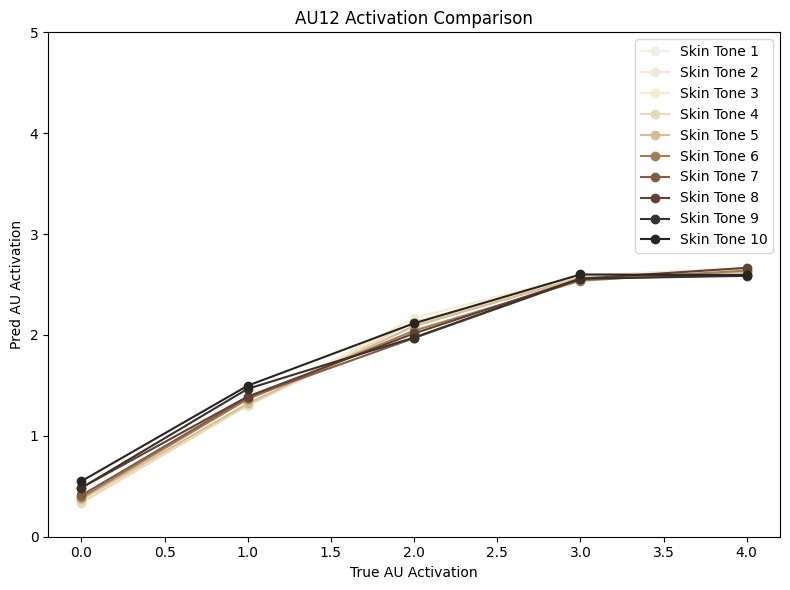

Results:
  Skin Tone     Slope  Mean Absolute Difference from True AU Activation
0         1  0.586518                                          0.503057
1         2  0.593645                                          0.495455
2         3  0.581218                                          0.523956
3         4  0.587517                                          0.511404
4         5  0.574103                                          0.519103
5         6  0.567259                                          0.523975
6         7  0.554589                                          0.534267
7         8  0.552792                                          0.533461
8         9  0.529421                                          0.566487
9        10  0.518868                                          0.594045


In [29]:
plot_columns_together_new('/Users/miguelmonares/FAU2/images/European_Woman', 'AU12', '12')

['ew1', 'ew2', 'ew3', 'ew4', 'ew5', 'ew6', 'ew7', 'ew8', 'ew9', 'ew10']
Slope of Skin Tone 1: 0.0092
Mean Absolute Difference from True AU Activation: 1.9822

Slope of Skin Tone 2: 0.0103
Mean Absolute Difference from True AU Activation: 1.9834

Slope of Skin Tone 3: 0.0105
Mean Absolute Difference from True AU Activation: 1.9835

Slope of Skin Tone 4: 0.0097
Mean Absolute Difference from True AU Activation: 1.9846

Slope of Skin Tone 5: 0.0099
Mean Absolute Difference from True AU Activation: 1.9836

Slope of Skin Tone 6: 0.0127
Mean Absolute Difference from True AU Activation: 1.9841

Slope of Skin Tone 7: 0.0126
Mean Absolute Difference from True AU Activation: 1.9860

Slope of Skin Tone 8: 0.0111
Mean Absolute Difference from True AU Activation: 1.9868

Slope of Skin Tone 9: 0.0095
Mean Absolute Difference from True AU Activation: 1.9849

Slope of Skin Tone 10: 0.0079
Mean Absolute Difference from True AU Activation: 1.9871



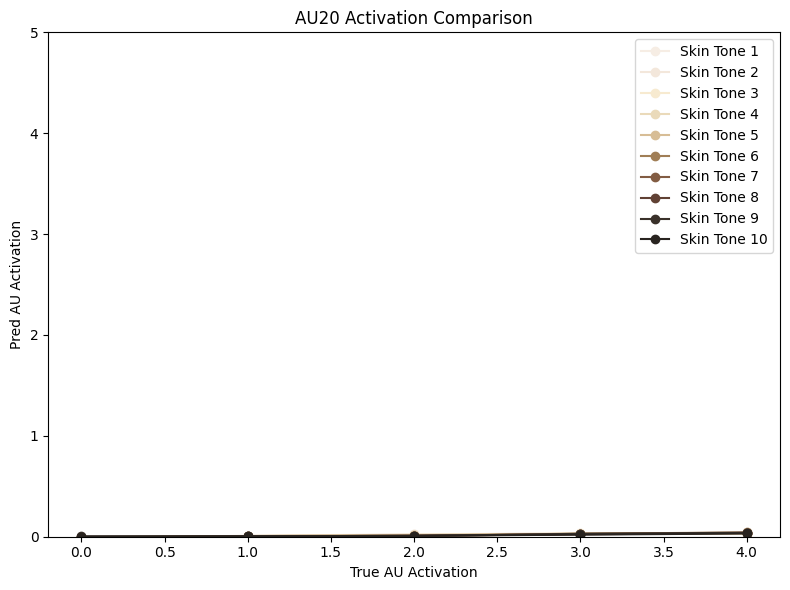

Results:
  Skin Tone     Slope  Mean Absolute Difference from True AU Activation
0         1  0.009172                                          1.982167
1         2  0.010332                                          1.983436
2         3  0.010473                                          1.983548
3         4  0.009722                                          1.984595
4         5  0.009924                                          1.983637
5         6  0.012679                                          1.984057
6         7  0.012570                                          1.985982
7         8  0.011064                                          1.986759
8         9  0.009451                                          1.984919
9        10  0.007862                                          1.987081


In [30]:
plot_columns_together_new('/Users/miguelmonares/FAU2/images/European_Woman', 'AU20', '20')

['ew1', 'ew2', 'ew3', 'ew4', 'ew5', 'ew6', 'ew7', 'ew8', 'ew9', 'ew10']
Slope of Skin Tone 1: 0.4381
Mean Absolute Difference from True AU Activation: 0.7334

Slope of Skin Tone 2: 0.3613
Mean Absolute Difference from True AU Activation: 0.8132

Slope of Skin Tone 3: 0.4450
Mean Absolute Difference from True AU Activation: 0.7369

Slope of Skin Tone 4: 0.4507
Mean Absolute Difference from True AU Activation: 0.7312

Slope of Skin Tone 5: 0.3541
Mean Absolute Difference from True AU Activation: 0.8147

Slope of Skin Tone 6: 0.3997
Mean Absolute Difference from True AU Activation: 0.8023

Slope of Skin Tone 7: 0.3265
Mean Absolute Difference from True AU Activation: 0.8882

Slope of Skin Tone 8: 0.3247
Mean Absolute Difference from True AU Activation: 0.8867

Slope of Skin Tone 9: 0.3885
Mean Absolute Difference from True AU Activation: 0.8031

Slope of Skin Tone 10: 0.4172
Mean Absolute Difference from True AU Activation: 0.7558



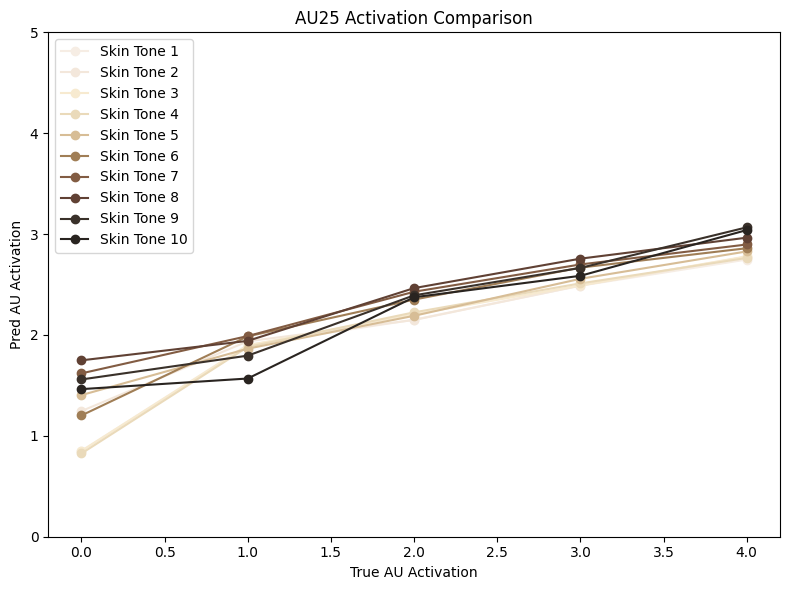

Results:
  Skin Tone     Slope  Mean Absolute Difference from True AU Activation
0         1  0.438131                                          0.733431
1         2  0.361325                                          0.813158
2         3  0.444983                                          0.736912
3         4  0.450685                                          0.731161
4         5  0.354127                                          0.814655
5         6  0.399701                                          0.802295
6         7  0.326468                                          0.888239
7         8  0.324658                                          0.886736
8         9  0.388531                                          0.803068
9        10  0.417186                                          0.755787


In [32]:
plot_columns_together_new('/Users/miguelmonares/FAU2/images/European_Woman', 'AU25', '25')

['ew1', 'ew2', 'ew3', 'ew4', 'ew5', 'ew6', 'ew7', 'ew8', 'ew9', 'ew10']
Slope of Skin Tone 1: 0.7948
Mean Absolute Difference from True AU Activation: 0.5581

Slope of Skin Tone 2: 0.8149
Mean Absolute Difference from True AU Activation: 0.5274

Slope of Skin Tone 3: 0.8172
Mean Absolute Difference from True AU Activation: 0.5152

Slope of Skin Tone 4: 0.8174
Mean Absolute Difference from True AU Activation: 0.5313

Slope of Skin Tone 5: 0.8436
Mean Absolute Difference from True AU Activation: 0.5215

Slope of Skin Tone 6: 0.8832
Mean Absolute Difference from True AU Activation: 0.4173

Slope of Skin Tone 7: 0.9330
Mean Absolute Difference from True AU Activation: 0.3860

Slope of Skin Tone 8: 0.9580
Mean Absolute Difference from True AU Activation: 0.3283

Slope of Skin Tone 9: 0.9693
Mean Absolute Difference from True AU Activation: 0.2602

Slope of Skin Tone 10: 1.0026
Mean Absolute Difference from True AU Activation: 0.1839



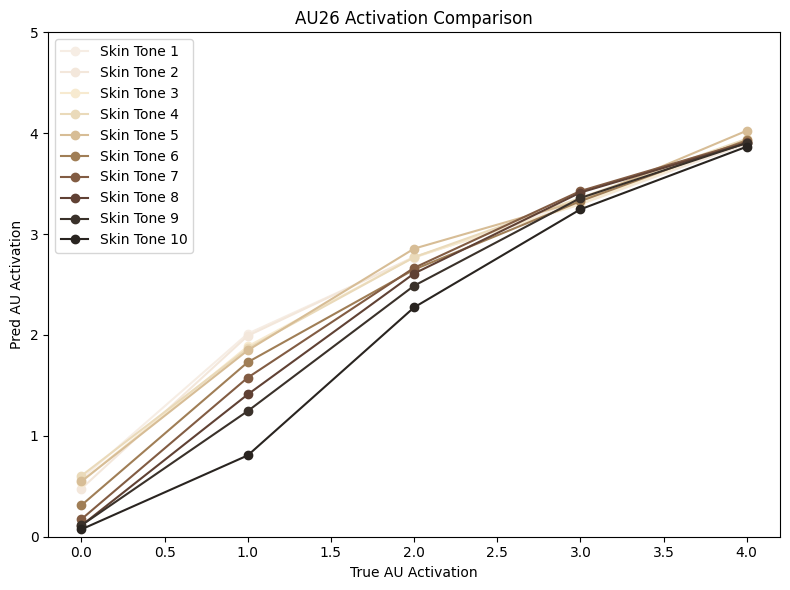

Results:
  Skin Tone     Slope  Mean Absolute Difference from True AU Activation
0         1  0.794777                                          0.558108
1         2  0.814873                                          0.527427
2         3  0.817158                                          0.515200
3         4  0.817350                                          0.531336
4         5  0.843572                                          0.521492
5         6  0.883227                                          0.417265
6         7  0.933016                                          0.386014
7         8  0.958046                                          0.328314
8         9  0.969310                                          0.260192
9        10  1.002573                                          0.183869


In [33]:
plot_columns_together_new('/Users/miguelmonares/FAU2/images/European_Woman', 'AU26', '26')